In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


In [55]:
# Check device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


# 2. Data Loading and Exploration

In [56]:
pwd

'e:\\RMIT\\Fourth-Semester\\Computational-MachineLearning\\Assignment-2\\ColonCancer-Classification-Project\\notebooks'

In [57]:

# Paths to your CSV files
main_labels_path = '../data/data_labels_mainData.csv'  # Adjust this based on where you store it
extra_labels_path = '../data/data_labels_extraData.csv'

# Load the CSVs
main_df = pd.read_csv(main_labels_path)
extra_df = pd.read_csv(extra_labels_path)

# Display the first few rows
print("Main Data Labels:")
display(main_df.head())

print("\nExtra Data Labels:")
display(extra_df.head())




Main Data Labels:


,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0



Extra Data Labels:


,InstanceID,patientID,ImageName,isCancerous
0,12681,61,12681.png,0
1,12682,61,12682.png,0
2,12683,61,12683.png,0
3,12684,61,12684.png,0
4,12685,61,12685.png,0


In [58]:
# Find common patient IDs between main_df and extra_df
common_patient_ids = set(main_df['patientID']).intersection(set(extra_df['patientID']))
print(f"Number of common patient IDs: {len(common_patient_ids)}")
print("Common patient IDs:", common_patient_ids)


Number of common patient IDs: 0
Common patient IDs: set()


In [59]:
# Add dummy column to extra_df so both have same structure
extra_df['cellType'] = None  # Task 1 doesn't need this anyway

# Combine the two
combined_df = pd.concat([main_df, extra_df], ignore_index=True)

# Optional: Reset index
combined_df.reset_index(drop=True, inplace=True)
combined_df = combined_df.drop(columns=['cellTypeName','cellType'])
display(combined_df.head())

print("Main df shape:",main_df.shape)
print("Extra df shape:",extra_df.shape)
print("Combined shape:", combined_df.shape)

,InstanceID,patientID,ImageName,isCancerous
0,22405,1,22405.png,0
1,22406,1,22406.png,0
2,22407,1,22407.png,0
3,22408,1,22408.png,0
4,22409,1,22409.png,0


Main df shape: (9896, 6)
Extra df shape: (10384, 5)
Combined shape: (20280, 4)


In [60]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20280 entries, 0 to 20279
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   InstanceID   20280 non-null  int64 
 1   patientID    20280 non-null  int64 
 2   ImageName    20280 non-null  object
 3   isCancerous  20280 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 633.9+ KB


In [61]:
# Check class balance in Main Data
print("isCancerous Distribution in Combined Data:")
print(combined_df['isCancerous'].value_counts())

# print("\ncellType Distribution in Main Data:")
# print(combined_df['cellType'].value_counts())

# Check class balance in Extra Data
# print("\nisCancerous Distribution in Extra Data:")
# print(combined_df['isCancerous'].value_counts())



isCancerous Distribution in Combined Data:
isCancerous
0    13211
1     7069
Name: count, dtype: int64


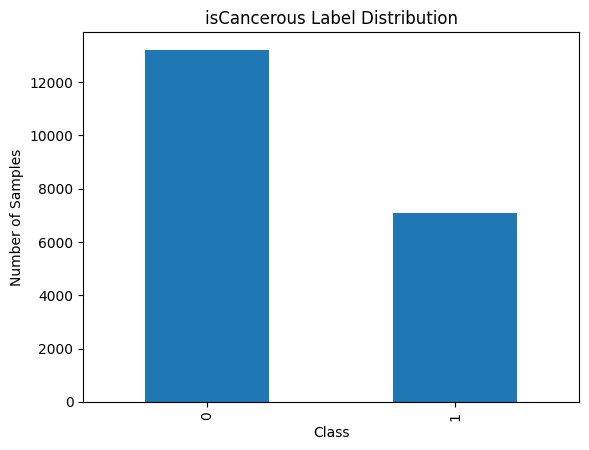

In [62]:
import matplotlib.pyplot as plt

# Plot isCancerous distribution
combined_df['isCancerous'].value_counts().plot(kind='bar')
plt.title('isCancerous Label Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()

# # Plot cellType distribution
# combined_df['cellType'].value_counts().plot(kind='bar')
# plt.title('cellType Label Distribution')
# plt.xlabel('Cell Type')
# plt.ylabel('Number of Samples')
# plt.show()


## Here are some exploratory data analysis (EDA) steps you can perform on `combined_df`:

1. **Basic Statistics**:
    - Check the distribution of numerical columns.
    - Identify missing values.

    ```python
    print(combined_df.describe())
    print(combined_df.isnull().sum())
    ```

2. **Class Distribution**:
    - Analyze the distribution of the `isCancerous` column.

    ```python
    print(combined_df['isCancerous'].value_counts())
    combined_df['isCancerous'].value_counts().plot(kind='bar', title='Class Distribution')
    plt.show()
    ```

3. **Patient Analysis**:
    - Check the number of unique patients and their sample counts.

    ```python
    print(combined_df['patientID'].nunique())
    print(combined_df['patientID'].value_counts())
    ```

4. **Image Analysis**:
    - Verify if all images are unique.

    ```python
    print(combined_df['ImageName'].nunique() == len(combined_df))
    ```

5. **Correlation Analysis**:
    - Check for correlations between numerical columns.

    ```python
    print(combined_df.corr())
    sns.heatmap(combined_df.corr(), annot=True, cmap='coolwarm')
    plt.show()
    ```

6. **Data Distribution by Patient**:
    - Analyze the distribution of `isCancerous` by `patientID`.

    ```python
    patient_cancer_dist = combined_df.groupby('patientID')['isCancerous'].mean()
    patient_cancer_dist.plot(kind='hist', title='Cancerous Distribution by Patient')
    plt.show()
    ```

7. **Outlier Detection**:
    - Identify potential outliers in numerical columns.

    ```python
    sns.boxplot(data=combined_df[['InstanceID', 'patientID']])
    plt.show()
    ```

8. **Sample Visualization**:
    - Display random samples of images (if accessible).

    ```python
    sample_images = combined_df.sample(5)
    for _, row in sample_images.iterrows():
         img_path = os.path.join(image_dir, row['ImageName'])
         img = Image.open(img_path)
         plt.imshow(img)
         plt.title(f"isCancerous: {row['isCancerous']}")
         plt.axis('off')
         plt.show()
    ```

These steps will help you understand the dataset better and identify any issues or patterns.

Patient Cancerous Distribution:
patientID
1     0.000000
2     0.000000
3     0.000000
4     0.000000
5     0.207101
6     0.141414
7     0.241107
8     0.849398
9     0.425287
10    0.513245
Name: isCancerous, dtype: float64


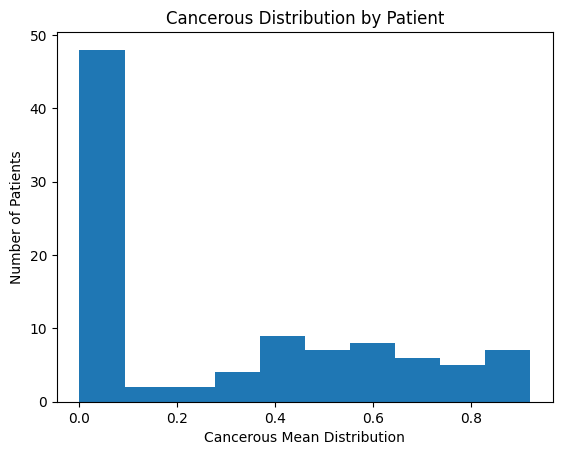

In [63]:
patient_cancer_dist = combined_df.groupby('patientID')['isCancerous'].mean()
print("Patient Cancerous Distribution:")
print(patient_cancer_dist.head(10))
patient_cancer_dist.plot(kind='hist', title='Cancerous Distribution by Patient')
plt.xlabel('Cancerous Mean Distribution')
plt.ylabel('Number of Patients')
plt.show()

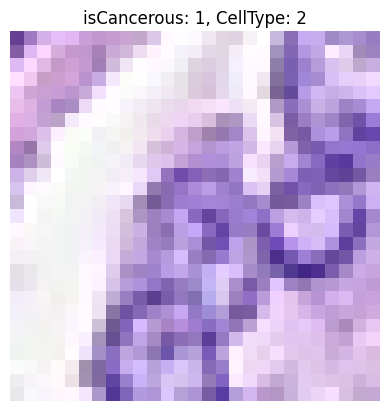

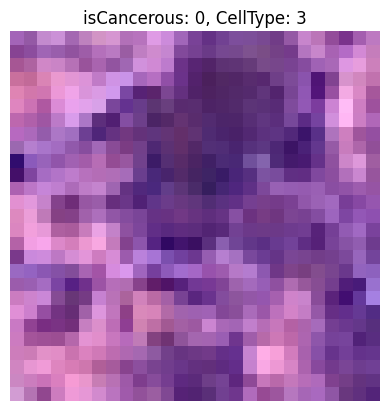

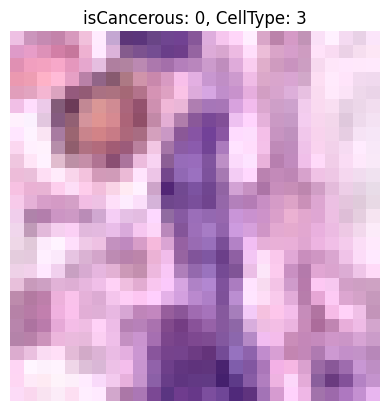

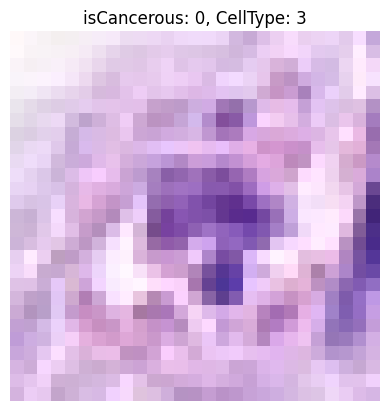

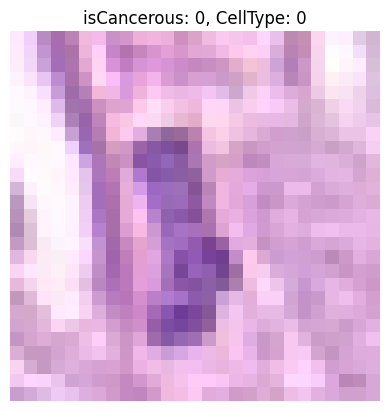

In [64]:
# Sample Image Folder
image_dir = '../data/patch_images/'  # Adjust path as needed

# Display a few random samples
sample_images = main_df.sample(5)  # Randomly pick 5 images

for idx, row in sample_images.iterrows():
    img_path = os.path.join(image_dir, row['ImageName'])
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(f"isCancerous: {row['isCancerous']}, CellType: {row.get('cellType', 'N/A')}")
    plt.axis('off')
    plt.show()


**Preprocessing Notes:**

- **Image Size:** All images are 27x27 RGB, no resizing needed.
- **Normalization:** Apply transforms.ToTensor() followed by transforms.Normalize((0.5,), (0.5,)) to scale pixel values to [-1,1] for better CNN performance.
- **Label Encoding:** 
  - For Task 1 (Cancer detection): Use the `isCancerous` binary label (0/1).
  - For Task 2 (Cell type classification): Encode string cell types into integer classes.
- **Data Splitting:** Dataset will be split into 70% training, 15% validation, 15% testing, stratified by `isCancerous` labels to preserve class balance.
- **Additional Observations:** Dataset shows slight class imbalance (e.g., more epithelial cells), but manageable without aggressive augmentation initially.


# 3. Data Preprocessing


## 3.1 Image Transformations (Preprocessing)

In [65]:
# transform = transforms.Compose([
#     transforms.ToTensor(),                 # PIL Image -> Tensor, and scales [0,255] to [0,1]
#     transforms.Normalize((0.5,), (0.5,))    # Normalize [0,1] → [-1,1]
# ])

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # Normalize to [-1, 1]
])


## 3.2 Create a Custom PyTorch Dataset Class

### For TASK 01 & TASK 02

In [66]:
class ColonCancerDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, task='cancer'):
        self.dataframe = dataframe           # DataFrame with labels
        self.img_dir = img_dir                # Folder where images are stored
        self.transform = transform            # Any transforms (e.g., normalize)
        self.task = task                      # 'cancer' (binary) or 'celltype' (multi-class)
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.img_dir, self.dataframe.iloc[idx]['filename'])
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        # Get label
        if self.task == 'cancer':
            label = torch.tensor(self.dataframe.iloc[idx]['isCancerous'], dtype=torch.float32)
        elif self.task == 'celltype':
            label = torch.tensor(self.dataframe.iloc[idx]['cellTypeEncoded'], dtype=torch.long)
        
        return image, label


### For TASK 01

In [67]:
class CancerImageDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.data = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx]['ImageName']
        label = self.data.iloc[idx]['isCancerous']
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)


## Train/Validation/Test Split

In [68]:
# Split the main_df into train/validation/test
# train_df, temp_df = train_test_split(combined_df, test_size=0.3, stratify=combined_df['isCancerous'], random_state=42)
# val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['isCancerous'], random_state=42)

# print(f"Train set size: {len(train_df)}")
# print(f"Validation set size: {len(val_df)}")
# print(f"Test set size: {len(test_df)}")

combined_df['patientID'] = combined_df['ImageName'].apply(lambda x: x.split('_')[0])  # or other rule

unique_patients = combined_df['patientID'].unique()
train_patients, temp_patients = train_test_split(unique_patients, test_size=0.3, random_state=42)
val_patients, test_patients = train_test_split(temp_patients, test_size=0.5, random_state=42)

train_df = combined_df[combined_df['patientID'].isin(train_patients)]
val_df = combined_df[combined_df['patientID'].isin(val_patients)]
test_df = combined_df[combined_df['patientID'].isin(test_patients)]

print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")
# print(train_df)

Train set size: 14196
Validation set size: 3042
Test set size: 3042


## Create Datasets and DataLoaders

In [69]:
# train_dataset = ColonCancerDataset(train_df, image_dir, transform=transform)
# val_dataset = ColonCancerDataset(val_df, image_dir, transform=transform)
# test_dataset = ColonCancerDataset(test_df, image_dir, transform=transform)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32)
# test_loader = DataLoader(test_dataset, batch_size=32)

# image_dir = 'images'

train_dataset = CancerImageDataset(train_df, image_dir, transform)
val_dataset = CancerImageDataset(val_df, image_dir, transform)
test_dataset = CancerImageDataset(test_df, image_dir, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



# 4. Baseline model

In [70]:
# class CancerClassifierCNN(nn.Module):
#     def __init__(self):
#         super(CancerClassifierCNN, self).__init__()

#         # Convolutional layers
#         self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)   # input: [3, 27, 27] → [16, 27, 27]
#         self.pool = nn.MaxPool2d(2, 2)                            # → [16, 13, 13]
#         self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # → [32, 13, 13] → [32, 6, 6]

#         # Fully connected layer
#         self.fc1 = nn.Linear(32 * 6 * 6, 1)   # binary classification → 1 output neuron

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))   # conv1 + relu + pool
#         x = self.pool(F.relu(self.conv2(x)))   # conv2 + relu + pool
#         x = x.view(-1, 32 * 6 * 6)             # flatten
#         x = self.fc1(x)                        # final dense layer (no sigmoid here!)
#         return x


class CNNBaseline(nn.Module):
    def __init__(self):
        super(CNNBaseline, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        return self.fc_layers(x)


In [ ]:
# model = CancerClassifierCNN()

# criterion = nn.BCEWithLogitsLoss()               # binary classification
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)


CancerClassifierCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1152, out_features=1, bias=True)
)

## 5. Train the Model

In [71]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNBaseline().to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training Loop
for epoch in range(10):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/10], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/10], Loss: 0.3545
Epoch [2/10], Loss: 0.3074
Epoch [3/10], Loss: 0.2829
Epoch [4/10], Loss: 0.2642
Epoch [5/10], Loss: 0.2451
Epoch [6/10], Loss: 0.2297
Epoch [7/10], Loss: 0.1982
Epoch [8/10], Loss: 0.1773
Epoch [9/10], Loss: 0.1419
Epoch [10/10], Loss: 0.1174


In [72]:
def evaluate(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images).cpu().numpy()
            preds = (outputs > 0.5).astype(int).flatten()
            y_true.extend(labels.numpy())
            y_pred.extend(preds)
    print(classification_report(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred))

print("Validation Performance:")
evaluate(model, val_loader)

print("Test Performance:")
evaluate(model, test_loader)


Validation Performance:
              precision    recall  f1-score   support

         0.0       0.92      0.89      0.91      1999
         1.0       0.80      0.86      0.83      1043

    accuracy                           0.88      3042
   macro avg       0.86      0.87      0.87      3042
weighted avg       0.88      0.88      0.88      3042

[[1775  224]
 [ 145  898]]
Test Performance:
              precision    recall  f1-score   support

         0.0       0.93      0.89      0.91      1973
         1.0       0.81      0.87      0.84      1069

    accuracy                           0.88      3042
   macro avg       0.87      0.88      0.87      3042
weighted avg       0.89      0.88      0.88      3042

[[1750  223]
 [ 134  935]]
